# Car plate detection

import libraries

In [25]:
import os
import cv2
import glob
import numpy as np 
from lxml import etree
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras import layers, Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

initialize the image size 224 is the same size used in vgg16

In [26]:
IMAGE_SIZE = 224

read images and loop to resize them

In [27]:
img_dir = "/Users/arwa/Downloads/car_plates/images" # all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort()
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))

this method uses the xml foramt to extract the location of the plates using bndbox object

In [28]:
def resize_annotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [29]:
annotations_dir = '/Users/arwa/Downloads/car_plates/annotations' #annotations
text_files = [ '/Users/arwa/Downloads/car_plates/annotations/' + f for f in sorted(os.listdir(annotations_dir))]
y=[]
for i in text_files:
    y.append(resize_annotation(i))

showing sample of the data

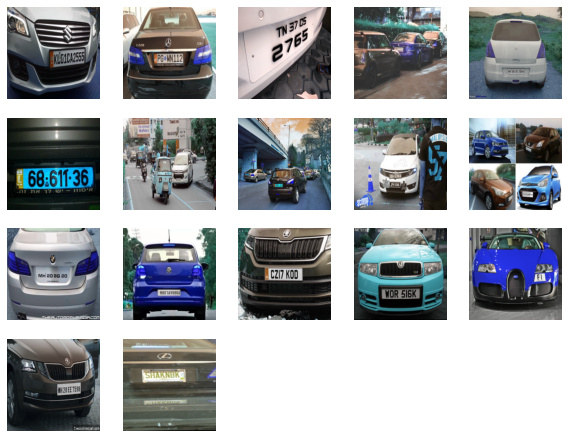

In [30]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

convert the images to array

In [31]:
X=np.array(X)
y=np.array(y)

normalize the data by dividing it by 255 to scale them between 0 and 1

In [32]:
X = X / 255
y = y / 255

splitting data to training, testing and validation

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

<h1>VGG16 Model<h1>

1. initaizing Sequential model to stack the layers in a lainear manner
2. add vgg16 with imagenet weights and set include_top=False so that the final fully connected layers of the VGG16 network are not included
3. frezze the first layers means that the weights of this layer will not be updated during training, and only the weights of the other layers will be learned.
4. flatten to convert the output to one dimensional vector
5. added 3 fully connected layer with relu activation function
6. last fully connected layer with sigmoid NOTE the number of neurons is 4 => the number of extracted location

In [34]:
vgg16_model = Sequential()
vgg16_model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

for layer in vgg16_model.layers:
    layer.trainable = False
    
vgg16_model.add(Flatten())
vgg16_model.add(Dense(128, activation="relu"))
vgg16_model.add(Dense(128, activation="relu"))
vgg16_model.add(Dense(128, activation="relu"))
vgg16_model.add(Dense(4, activation="sigmoid"))

used mean squared error loss function and adam as optimizer

In [35]:
vgg16_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

fitting the data to the model 
I used early stopping to stop the model when the validation loss increases

In [36]:
train = vgg16_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/50
10/10 [==============================] - 95s 9s/step - loss: 0.1154 - accuracy: 0.4502 - val_loss: 0.0827 - val_accuracy: 0.5429
Epoch 2/50
10/10 [==============================] - 86s 9s/step - loss: 0.0751 - accuracy: 0.4437 - val_loss: 0.0705 - val_accuracy: 0.5429
Epoch 3/50
10/10 [==============================] - 85s 9s/step - loss: 0.0660 - accuracy: 0.4437 - val_loss: 0.0637 - val_accuracy: 0.5429
Epoch 4/50
10/10 [==============================] - 86s 9s/step - loss: 0.0626 - accuracy: 0.4437 - val_loss: 0.0626 - val_accuracy: 0.5429
Epoch 5/50
10/10 [==============================] - 87s 9s/step - loss: 0.0586 - accuracy: 0.4437 - val_loss: 0.0531 - val_accuracy: 0.5429
Epoch 6/50
10/10 [==============================] - 84s 8s/step - loss: 0.0223 - accuracy: 0.5691 - val_loss: 0.0184 - val_accuracy: 0.5714
Epoch 7/50
10/10 [==============================] - 84s 8s/step - loss: 0.0082 - accuracy: 0.6817 - val_loss: 0.0174 - val_accuracy: 0.6571
Epoch 8/50
10/10 [==

In [37]:
scores = vgg16_model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 86.21%


In [38]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Scores')
    plt.legend()
    plt.show()

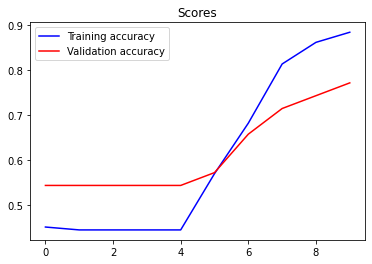

In [39]:
plot_scores(train)

In [40]:
y_pred = vgg16_model.predict(X_test)

3/3 [==============================] - 31s 10s/step


sample of predication in the test data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

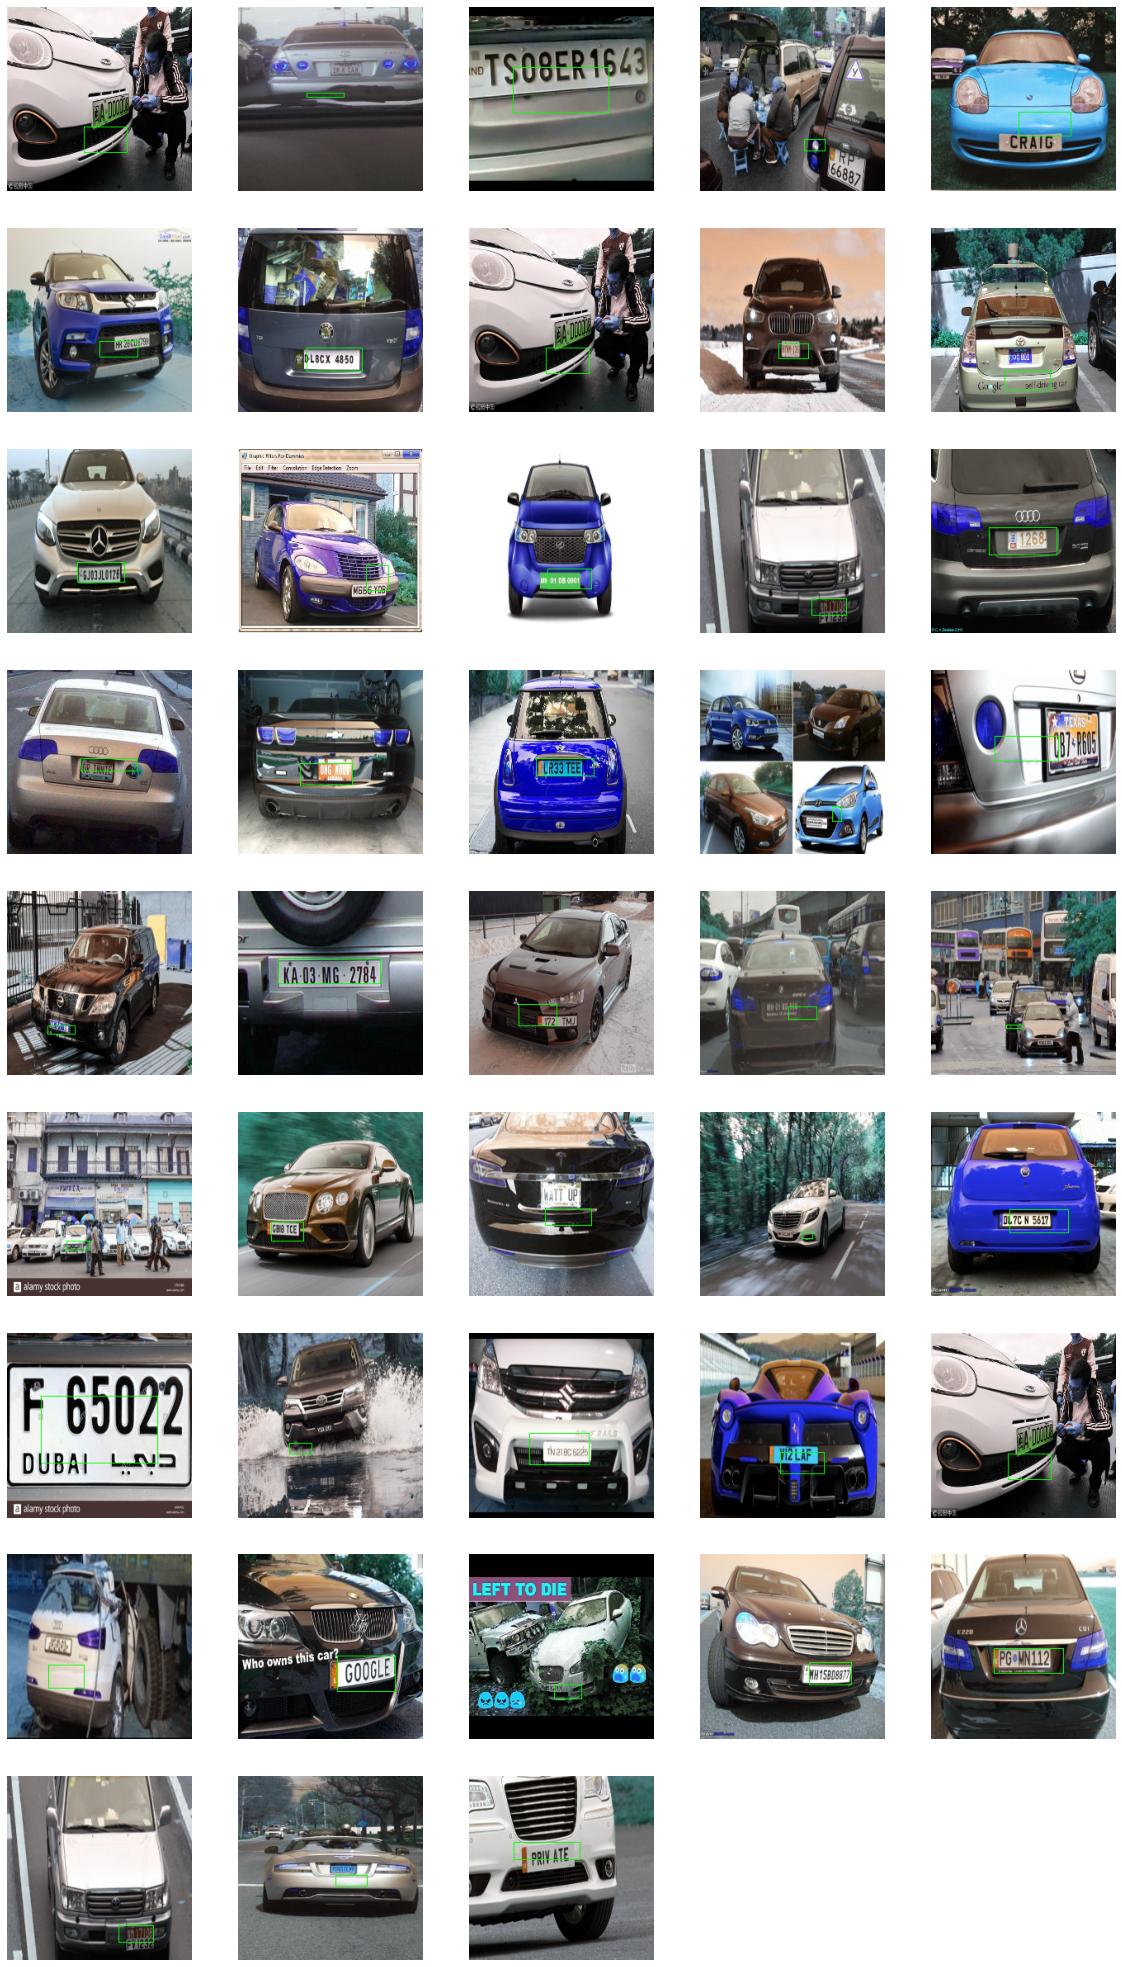

In [41]:
plt.figure(figsize=(20,40))

for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_pred[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

<h1>RESNET Model<h1>

In [18]:
resnet_model = Sequential()
resnet_model = tf.keras.applications.ResNet50V2(weights = 'imagenet', include_top = False,
                                              input_shape =(IMAGE_SIZE, IMAGE_SIZE, 3))
for layer in resnet_model.layers:
    layer.trainable = False

resnet_headmodel = resnet_model.output
resnet_headmodel = layers.Flatten()(resnet_headmodel)
#resnet_headmodel = layers.Dense(128, activation="relu")(resnet_headmodel)
resnet_headmodel = layers.Dense(128, activation="relu")(resnet_headmodel)
resnet_headmodel = layers.Dense(256, activation="relu")(resnet_headmodel)
resnet_headmodel = layers.Dense(4, activation="sigmoid")(resnet_headmodel)

resnet_model = Model(inputs = resnet_model.input, outputs = resnet_headmodel)

In [19]:
resnet_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

In [20]:
resnet_fit = resnet_model.fit(X_train, y_train, 
                           validation_data=(X_val, y_val), epochs=50,
                           batch_size=15, verbose=1,
                           callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/50
21/21 [==============================] - 32s 1s/step - loss: 0.0506 - accuracy: 0.5177 - val_loss: 0.0341 - val_accuracy: 0.4571
Epoch 2/50
21/21 [==============================] - 28s 1s/step - loss: 0.0235 - accuracy: 0.5788 - val_loss: 0.0238 - val_accuracy: 0.3714
Epoch 3/50
21/21 [==============================] - 28s 1s/step - loss: 0.0123 - accuracy: 0.6559 - val_loss: 0.0196 - val_accuracy: 0.5714
Epoch 4/50
21/21 [==============================] - 28s 1s/step - loss: 0.0070 - accuracy: 0.7814 - val_loss: 0.0180 - val_accuracy: 0.4857
Epoch 5/50
21/21 [==============================] - 28s 1s/step - loss: 0.0055 - accuracy: 0.8006 - val_loss: 0.0171 - val_accuracy: 0.6000
Epoch 6/50
21/21 [==============================] - 28s 1s/step - loss: 0.0046 - accuracy: 0.8071 - val_loss: 0.0163 - val_accuracy: 0.5429
Epoch 7/50
21/21 [==============================] - 28s 1s/step - loss: 0.0039 - accuracy: 0.8328 - val_loss: 0.0166 - val_accuracy: 0.6571


In [21]:
scores = resnet_model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 63.22%


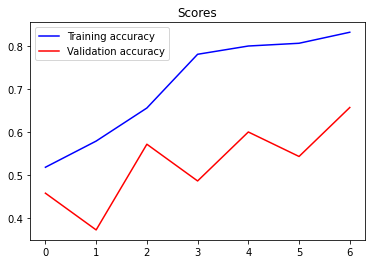

In [22]:
def plot_scores(train) :
    accuracy = resnet_fit.history['accuracy']
    val_accuracy = resnet_fit.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Scores')
    plt.legend()
    plt.show()

plot_scores(resnet_fit)

In [23]:
y_pred = resnet_model.predict(X_test)

3/3 [==============================] - 8s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

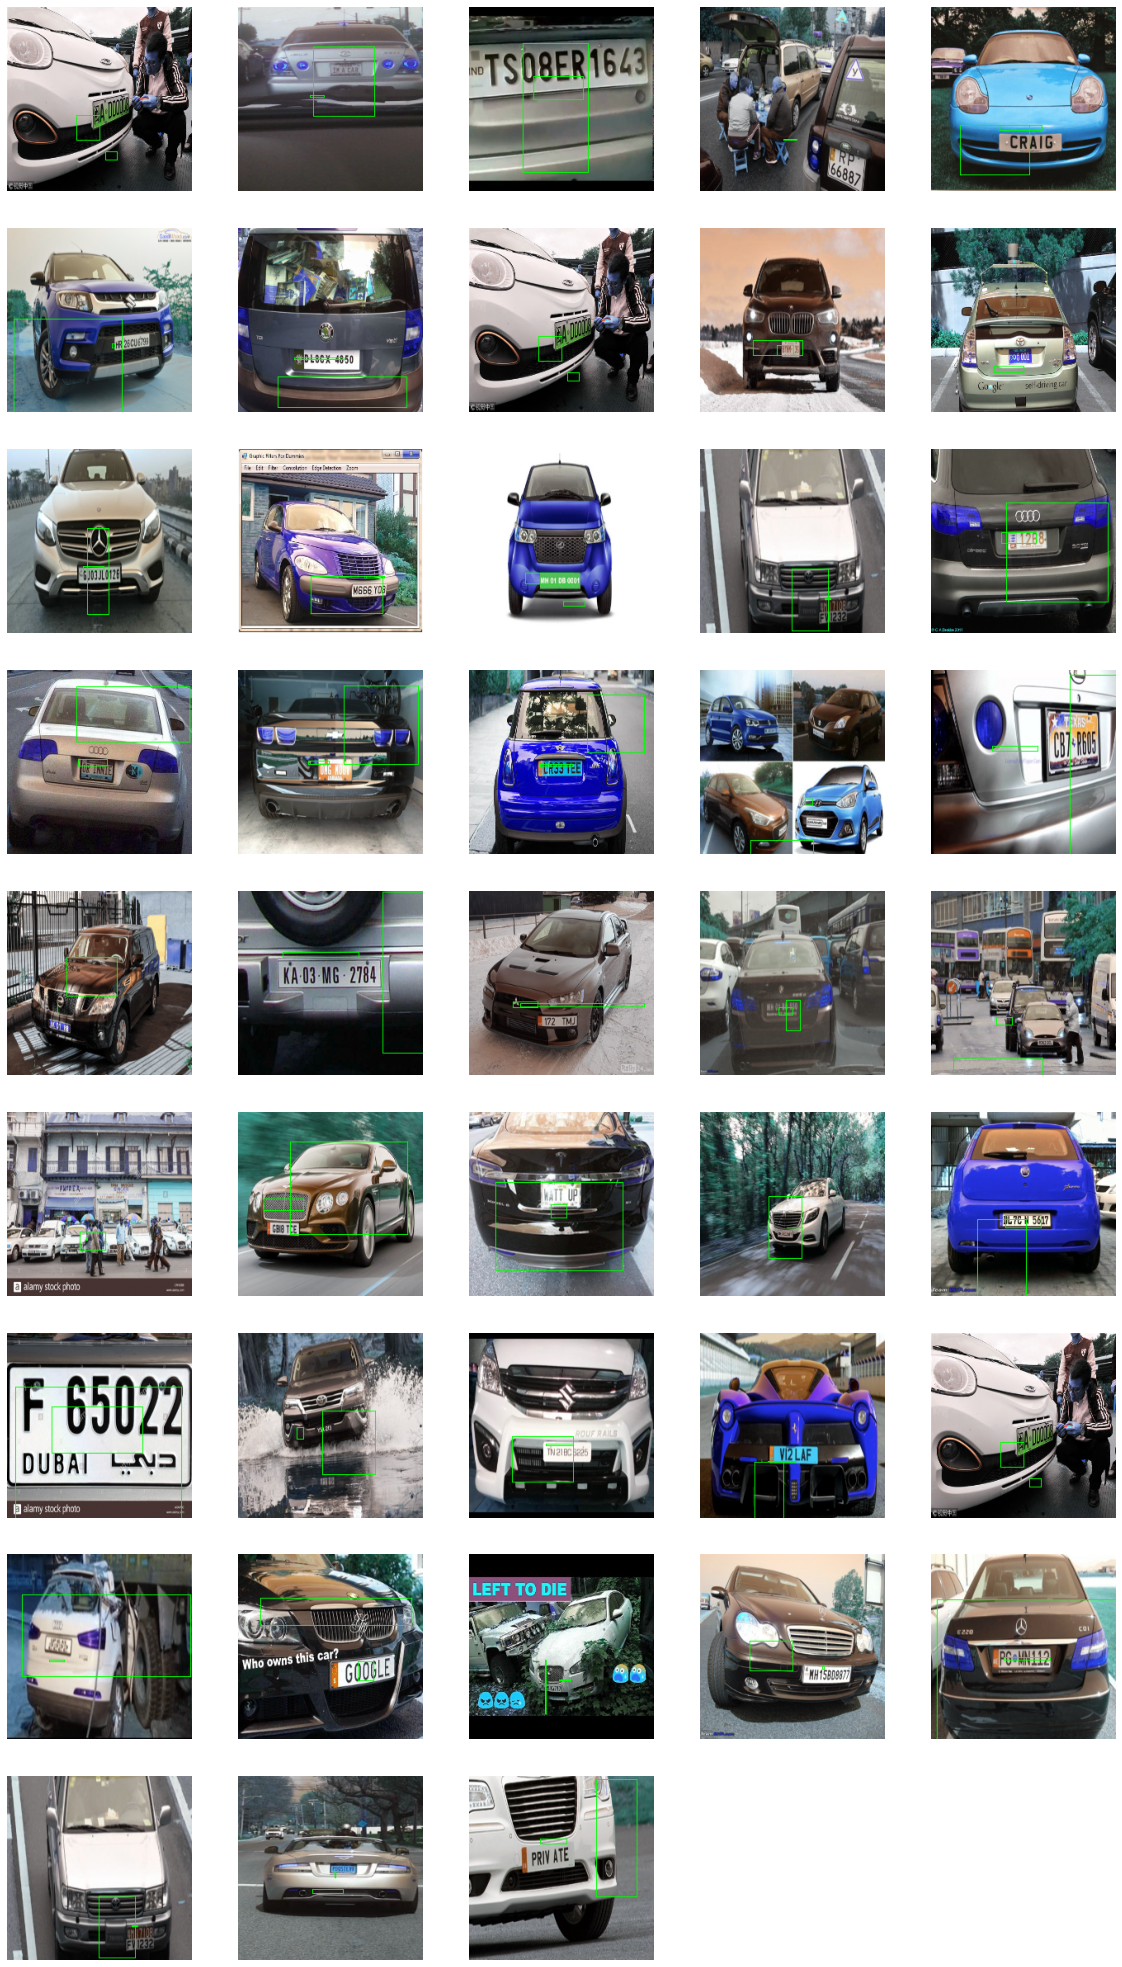

In [24]:
plt.figure(figsize=(20,40))

for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_pred[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)